# CBOW with Tensorflow

Continuous bag of words (CBOW) variant of word2vec: use surrounding words to predict the middle word.

Playground for trying out different feedforward NN is at:

https://playground.tensorflow.org/

In [29]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import roc_auc_score, f1_score, confusion_matrix

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

from tensorflow.keras.layers import Dense, Input, Embedding, Lambda
from tensorflow.keras.models import Model

tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

In [1]:
import gensim.downloader as api 
dataset = api.load("text8")

[=====================================-------------] 74.0% 23.4/31.6MB downloaded

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



[==================================================] 100.0% 31.6/31.6MB downloaded


In [2]:
type(dataset)

text8.Dataset

In [3]:
i = 0
for x in dataset:
    print(x)
    i += 1
    if i > 10:
        break

['anarchism', 'originated', 'as', 'a', 'term', 'of', 'abuse', 'first', 'used', 'against', 'early', 'working', 'class', 'radicals', 'including', 'the', 'diggers', 'of', 'the', 'english', 'revolution', 'and', 'the', 'sans', 'culottes', 'of', 'the', 'french', 'revolution', 'whilst', 'the', 'term', 'is', 'still', 'used', 'in', 'a', 'pejorative', 'way', 'to', 'describe', 'any', 'act', 'that', 'used', 'violent', 'means', 'to', 'destroy', 'the', 'organization', 'of', 'society', 'it', 'has', 'also', 'been', 'taken', 'up', 'as', 'a', 'positive', 'label', 'by', 'self', 'defined', 'anarchists', 'the', 'word', 'anarchism', 'is', 'derived', 'from', 'the', 'greek', 'without', 'archons', 'ruler', 'chief', 'king', 'anarchism', 'as', 'a', 'political', 'philosophy', 'is', 'the', 'belief', 'that', 'rulers', 'are', 'unnecessary', 'and', 'should', 'be', 'abolished', 'although', 'there', 'are', 'differing', 'interpretations', 'of', 'what', 'this', 'means', 'anarchism', 'also', 'refers', 'to', 'related', 'so

In [7]:
i = 0
doc_length = []
for x in dataset:
    i += 1
    doc_length.append(len(x))
print(i)

1701


(array([1.0e+00, 0.0e+00, 0.0e+00, 0.0e+00, 0.0e+00, 0.0e+00, 0.0e+00,
        0.0e+00, 0.0e+00, 0.0e+00, 0.0e+00, 0.0e+00, 0.0e+00, 0.0e+00,
        0.0e+00, 0.0e+00, 0.0e+00, 0.0e+00, 0.0e+00, 0.0e+00, 0.0e+00,
        0.0e+00, 0.0e+00, 0.0e+00, 0.0e+00, 0.0e+00, 0.0e+00, 0.0e+00,
        0.0e+00, 0.0e+00, 0.0e+00, 0.0e+00, 0.0e+00, 0.0e+00, 0.0e+00,
        0.0e+00, 0.0e+00, 0.0e+00, 0.0e+00, 0.0e+00, 0.0e+00, 0.0e+00,
        0.0e+00, 0.0e+00, 0.0e+00, 0.0e+00, 0.0e+00, 0.0e+00, 0.0e+00,
        1.7e+03]),
 array([ 5207.  ,  5302.86,  5398.72,  5494.58,  5590.44,  5686.3 ,
         5782.16,  5878.02,  5973.88,  6069.74,  6165.6 ,  6261.46,
         6357.32,  6453.18,  6549.04,  6644.9 ,  6740.76,  6836.62,
         6932.48,  7028.34,  7124.2 ,  7220.06,  7315.92,  7411.78,
         7507.64,  7603.5 ,  7699.36,  7795.22,  7891.08,  7986.94,
         8082.8 ,  8178.66,  8274.52,  8370.38,  8466.24,  8562.1 ,
         8657.96,  8753.82,  8849.68,  8945.54,  9041.4 ,  9137.26,
        

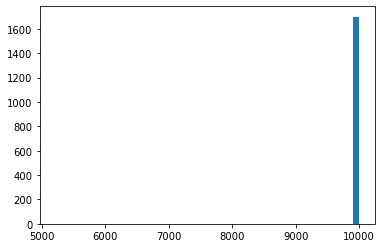

In [26]:
plt.hist(doc_length, bins=50)

In [16]:
np.mean(doc_length), np.std(doc_length)

(9997.182245737802, 116.17898450079628)

In [17]:
# building word2idx

from tensorflow.keras.preprocessing.text import Tokenizer

In [18]:
vocab_size = 20_000
tokenizer = Tokenizer(num_words=vocab_size)
tokenizer.fit_on_texts(dataset)
sequences = tokenizer.texts_to_sequences(dataset)

In [19]:
len(sequences)

1701

In [20]:
len(sequences[0])

9538

In [21]:
tokenizer.num_words

20000

In [22]:
len(tokenizer.word_index)

253854

In [23]:
tokenizer.word_index

{'the': 1,
 'of': 2,
 'and': 3,
 'one': 4,
 'in': 5,
 'a': 6,
 'to': 7,
 'zero': 8,
 'nine': 9,
 'two': 10,
 'is': 11,
 'as': 12,
 'eight': 13,
 'for': 14,
 's': 15,
 'five': 16,
 'three': 17,
 'was': 18,
 'by': 19,
 'that': 20,
 'four': 21,
 'six': 22,
 'seven': 23,
 'with': 24,
 'on': 25,
 'are': 26,
 'it': 27,
 'from': 28,
 'or': 29,
 'his': 30,
 'an': 31,
 'be': 32,
 'this': 33,
 'which': 34,
 'at': 35,
 'he': 36,
 'also': 37,
 'not': 38,
 'have': 39,
 'were': 40,
 'has': 41,
 'but': 42,
 'other': 43,
 'their': 44,
 'its': 45,
 'first': 46,
 'they': 47,
 'some': 48,
 'had': 49,
 'all': 50,
 'more': 51,
 'most': 52,
 'can': 53,
 'been': 54,
 'such': 55,
 'many': 56,
 'who': 57,
 'new': 58,
 'used': 59,
 'there': 60,
 'after': 61,
 'when': 62,
 'into': 63,
 'american': 64,
 'time': 65,
 'these': 66,
 'only': 67,
 'see': 68,
 'may': 69,
 'than': 70,
 'world': 71,
 'i': 72,
 'b': 73,
 'would': 74,
 'd': 75,
 'no': 76,
 'however': 77,
 'between': 78,
 'about': 79,
 'over': 80,
 'years':

In [24]:
tokenizer.index_word

{1: 'the',
 2: 'of',
 3: 'and',
 4: 'one',
 5: 'in',
 6: 'a',
 7: 'to',
 8: 'zero',
 9: 'nine',
 10: 'two',
 11: 'is',
 12: 'as',
 13: 'eight',
 14: 'for',
 15: 's',
 16: 'five',
 17: 'three',
 18: 'was',
 19: 'by',
 20: 'that',
 21: 'four',
 22: 'six',
 23: 'seven',
 24: 'with',
 25: 'on',
 26: 'are',
 27: 'it',
 28: 'from',
 29: 'or',
 30: 'his',
 31: 'an',
 32: 'be',
 33: 'this',
 34: 'which',
 35: 'at',
 36: 'he',
 37: 'also',
 38: 'not',
 39: 'have',
 40: 'were',
 41: 'has',
 42: 'but',
 43: 'other',
 44: 'their',
 45: 'its',
 46: 'first',
 47: 'they',
 48: 'some',
 49: 'had',
 50: 'all',
 51: 'more',
 52: 'most',
 53: 'can',
 54: 'been',
 55: 'such',
 56: 'many',
 57: 'who',
 58: 'new',
 59: 'used',
 60: 'there',
 61: 'after',
 62: 'when',
 63: 'into',
 64: 'american',
 65: 'time',
 66: 'these',
 67: 'only',
 68: 'see',
 69: 'may',
 70: 'than',
 71: 'world',
 72: 'i',
 73: 'b',
 74: 'would',
 75: 'd',
 76: 'no',
 77: 'however',
 78: 'between',
 79: 'about',
 80: 'over',
 81: 'yea

In [27]:
import random
random.seed(1)
np.random.seed(1)
tf.random.set_seed(1)

In [30]:
# build model

context_size = 10
embedding_dim = 50

i = Input(shape=(context_size,))
x = Embedding(vocab_size, embedding_dim)(i)
x = Lambda(lambda t: tf.reduce_mean(t, axis=1))(x)
x = Dense(vocab_size, use_bias=False)(x)

model = Model(i, x)

2022-09-04 22:27:19.385901: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [31]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 10)]              0         
                                                                 
 embedding (Embedding)       (None, 10, 50)            1000000   
                                                                 
 lambda (Lambda)             (None, 50)                0         
                                                                 
 dense (Dense)               (None, 20000)             1000000   
                                                                 
Total params: 2,000,000
Trainable params: 2,000,000
Non-trainable params: 0
_________________________________________________________________


In [32]:
half_context_size = context_size // 2

def data_generator(sequences, batch_size=128):
  X_batch = np.zeros((batch_size, context_size))
  Y_batch = np.zeros(batch_size)
  n_batches = int(np.ceil(len(sequences) / batch_size))
  while True:
    random.shuffle(sequences)

    # one epoch will be one pass through the data
    for i in range(n_batches):
      batch_sequences = sequences[i * batch_size:(i + 1) * batch_size]

      current_batch_size = len(batch_sequences) # may be less than batch_size
      for ii in range(current_batch_size):
        seq = batch_sequences[ii]
        j = np.random.randint(0, len(seq) - context_size - 1)
        x1 = seq[j:j + half_context_size]
        x2 = seq[j + half_context_size + 1:j + context_size + 1]
        # x = x1 + x2
        # X_batch[ii] = x
        X_batch[ii, :half_context_size] = x1
        X_batch[ii, half_context_size:] = x2
        y = seq[j + half_context_size]
        Y_batch[ii] = y
      
      yield X_batch[:current_batch_size], Y_batch[:current_batch_size]

In [34]:
model.compile(
  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
  optimizer='adam',
  metrics=['accuracy']
)

In [35]:
# takes about 46 min
batch_size = 128
r = model.fit(
  data_generator(sequences, batch_size),
  epochs=10000,
  steps_per_epoch=int(np.ceil(len(sequences) / batch_size))
)

Epoch 1/10000
14/14 [==============================] - 1s 19ms/step - loss: 9.9032 - accuracy: 0.0088
Epoch 2/10000
14/14 [==============================] - 0s 19ms/step - loss: 9.9018 - accuracy: 0.0664
Epoch 3/10000
14/14 [==============================] - 0s 21ms/step - loss: 9.8965 - accuracy: 0.0617
Epoch 4/10000
14/14 [==============================] - 0s 20ms/step - loss: 9.8826 - accuracy: 0.0570
Epoch 5/10000
14/14 [==============================] - 0s 21ms/step - loss: 9.8518 - accuracy: 0.0688
Epoch 6/10000
14/14 [==============================] - 0s 20ms/step - loss: 9.7965 - accuracy: 0.0682
Epoch 7/10000
14/14 [==============================] - 0s 20ms/step - loss: 9.7182 - accuracy: 0.0623
Epoch 8/10000
14/14 [==============================] - 0s 20ms/step - loss: 9.6031 - accuracy: 0.0752
Epoch 9/10000
14/14 [==============================] - 0s 19ms/step - loss: 9.4640 - accuracy: 0.0606
Epoch 10/10000
14/14 [==============================] - 0s 20ms/step - loss: 9.300

14/14 [==============================] - 0s 29ms/step - loss: 7.1208 - accuracy: 0.0705
Epoch 160/10000
14/14 [==============================] - 0s 28ms/step - loss: 6.9522 - accuracy: 0.0841
Epoch 161/10000
14/14 [==============================] - 0s 31ms/step - loss: 6.8998 - accuracy: 0.0882
Epoch 162/10000
14/14 [==============================] - 0s 29ms/step - loss: 6.8763 - accuracy: 0.0858
Epoch 163/10000
14/14 [==============================] - 0s 27ms/step - loss: 7.0560 - accuracy: 0.0705
Epoch 164/10000
14/14 [==============================] - 0s 28ms/step - loss: 7.0905 - accuracy: 0.0735
Epoch 165/10000
14/14 [==============================] - 0s 30ms/step - loss: 7.0289 - accuracy: 0.0788
Epoch 166/10000
14/14 [==============================] - 0s 31ms/step - loss: 6.8615 - accuracy: 0.0805
Epoch 167/10000
14/14 [==============================] - 0s 28ms/step - loss: 6.9313 - accuracy: 0.0752
Epoch 168/10000
14/14 [==============================] - 0s 31ms/step - loss: 6.

14/14 [==============================] - 0s 33ms/step - loss: 6.9354 - accuracy: 0.0800
Epoch 316/10000
14/14 [==============================] - 0s 29ms/step - loss: 6.9376 - accuracy: 0.0852
Epoch 317/10000
14/14 [==============================] - 0s 32ms/step - loss: 6.8616 - accuracy: 0.0929
Epoch 318/10000
14/14 [==============================] - 1s 37ms/step - loss: 6.8387 - accuracy: 0.1011
Epoch 319/10000
14/14 [==============================] - 1s 36ms/step - loss: 6.8107 - accuracy: 0.0899
Epoch 320/10000
14/14 [==============================] - 0s 32ms/step - loss: 6.8247 - accuracy: 0.0952
Epoch 321/10000
14/14 [==============================] - 0s 32ms/step - loss: 6.8922 - accuracy: 0.0876
Epoch 322/10000
14/14 [==============================] - 0s 32ms/step - loss: 6.8125 - accuracy: 0.0817
Epoch 323/10000
14/14 [==============================] - 0s 33ms/step - loss: 6.8350 - accuracy: 0.0888
Epoch 324/10000
14/14 [==============================] - 0s 35ms/step - loss: 6.

14/14 [==============================] - 0s 32ms/step - loss: 6.8690 - accuracy: 0.0964
Epoch 472/10000
14/14 [==============================] - 0s 35ms/step - loss: 6.7809 - accuracy: 0.0917
Epoch 473/10000
14/14 [==============================] - 0s 33ms/step - loss: 6.9040 - accuracy: 0.0894
Epoch 474/10000
14/14 [==============================] - 0s 32ms/step - loss: 6.9639 - accuracy: 0.0829
Epoch 475/10000
14/14 [==============================] - 0s 35ms/step - loss: 6.8427 - accuracy: 0.1052
Epoch 476/10000
14/14 [==============================] - 0s 33ms/step - loss: 6.7924 - accuracy: 0.0994
Epoch 477/10000
14/14 [==============================] - 0s 33ms/step - loss: 6.7442 - accuracy: 0.1082
Epoch 478/10000
14/14 [==============================] - 1s 37ms/step - loss: 6.8444 - accuracy: 0.0964
Epoch 479/10000
14/14 [==============================] - 0s 34ms/step - loss: 6.8290 - accuracy: 0.0917
Epoch 480/10000
14/14 [==============================] - 0s 33ms/step - loss: 6.

14/14 [==============================] - 0s 32ms/step - loss: 6.7792 - accuracy: 0.1170
Epoch 628/10000
14/14 [==============================] - 0s 30ms/step - loss: 6.7929 - accuracy: 0.0999
Epoch 629/10000
14/14 [==============================] - 0s 34ms/step - loss: 6.7482 - accuracy: 0.0999
Epoch 630/10000
14/14 [==============================] - 0s 32ms/step - loss: 6.7096 - accuracy: 0.1093
Epoch 631/10000
14/14 [==============================] - 0s 33ms/step - loss: 6.8553 - accuracy: 0.1017
Epoch 632/10000
14/14 [==============================] - 0s 32ms/step - loss: 6.7581 - accuracy: 0.1064
Epoch 633/10000
14/14 [==============================] - 0s 33ms/step - loss: 6.5644 - accuracy: 0.1035
Epoch 634/10000
14/14 [==============================] - 0s 34ms/step - loss: 6.8581 - accuracy: 0.0876
Epoch 635/10000
14/14 [==============================] - 0s 31ms/step - loss: 6.6928 - accuracy: 0.1011
Epoch 636/10000
14/14 [==============================] - 0s 31ms/step - loss: 6.

14/14 [==============================] - 0s 30ms/step - loss: 6.7801 - accuracy: 0.0976
Epoch 784/10000
14/14 [==============================] - 0s 35ms/step - loss: 6.7515 - accuracy: 0.0988
Epoch 785/10000
14/14 [==============================] - 0s 33ms/step - loss: 6.7613 - accuracy: 0.1023
Epoch 786/10000
14/14 [==============================] - 0s 32ms/step - loss: 6.6129 - accuracy: 0.1088
Epoch 787/10000
14/14 [==============================] - 0s 34ms/step - loss: 6.8248 - accuracy: 0.0899
Epoch 788/10000
14/14 [==============================] - 0s 34ms/step - loss: 6.7919 - accuracy: 0.0976
Epoch 789/10000
14/14 [==============================] - 1s 36ms/step - loss: 6.7575 - accuracy: 0.0994
Epoch 790/10000
14/14 [==============================] - 0s 34ms/step - loss: 6.7568 - accuracy: 0.1058
Epoch 791/10000
14/14 [==============================] - 0s 35ms/step - loss: 6.6552 - accuracy: 0.1123
Epoch 792/10000
14/14 [==============================] - 1s 37ms/step - loss: 6.

14/14 [==============================] - 0s 36ms/step - loss: 6.7353 - accuracy: 0.1146
Epoch 940/10000
14/14 [==============================] - 1s 36ms/step - loss: 6.8018 - accuracy: 0.1082
Epoch 941/10000
14/14 [==============================] - 1s 37ms/step - loss: 6.6792 - accuracy: 0.0988
Epoch 942/10000
14/14 [==============================] - 1s 35ms/step - loss: 6.7075 - accuracy: 0.1029
Epoch 943/10000
14/14 [==============================] - 0s 34ms/step - loss: 6.6808 - accuracy: 0.1099
Epoch 944/10000
14/14 [==============================] - 1s 36ms/step - loss: 6.6631 - accuracy: 0.1152
Epoch 945/10000
14/14 [==============================] - 1s 39ms/step - loss: 6.6955 - accuracy: 0.1005
Epoch 946/10000
14/14 [==============================] - 0s 34ms/step - loss: 6.7246 - accuracy: 0.1058
Epoch 947/10000
14/14 [==============================] - 0s 34ms/step - loss: 6.7249 - accuracy: 0.0994
Epoch 948/10000
14/14 [==============================] - 1s 37ms/step - loss: 6.

14/14 [==============================] - 0s 35ms/step - loss: 6.6978 - accuracy: 0.0988
Epoch 1096/10000
14/14 [==============================] - 1s 38ms/step - loss: 6.6945 - accuracy: 0.1129
Epoch 1097/10000
14/14 [==============================] - 1s 40ms/step - loss: 6.7504 - accuracy: 0.1082
Epoch 1098/10000
14/14 [==============================] - 1s 38ms/step - loss: 6.5611 - accuracy: 0.1082
Epoch 1099/10000
14/14 [==============================] - 1s 39ms/step - loss: 6.7904 - accuracy: 0.1023
Epoch 1100/10000
14/14 [==============================] - 1s 37ms/step - loss: 6.7328 - accuracy: 0.0911
Epoch 1101/10000
14/14 [==============================] - 0s 33ms/step - loss: 6.6859 - accuracy: 0.1011
Epoch 1102/10000
14/14 [==============================] - 1s 36ms/step - loss: 6.7043 - accuracy: 0.1070
Epoch 1103/10000
14/14 [==============================] - 0s 36ms/step - loss: 6.7238 - accuracy: 0.1041
Epoch 1104/10000
14/14 [==============================] - 0s 34ms/step -

14/14 [==============================] - 1s 36ms/step - loss: 6.7222 - accuracy: 0.0847
Epoch 1252/10000
14/14 [==============================] - 0s 34ms/step - loss: 6.6663 - accuracy: 0.0929
Epoch 1253/10000
14/14 [==============================] - 0s 35ms/step - loss: 6.6100 - accuracy: 0.1058
Epoch 1254/10000
14/14 [==============================] - 1s 36ms/step - loss: 6.5593 - accuracy: 0.1088
Epoch 1255/10000
14/14 [==============================] - 1s 37ms/step - loss: 6.5367 - accuracy: 0.1099
Epoch 1256/10000
14/14 [==============================] - 1s 36ms/step - loss: 6.5721 - accuracy: 0.1141
Epoch 1257/10000
14/14 [==============================] - 0s 35ms/step - loss: 6.5752 - accuracy: 0.1229
Epoch 1258/10000
14/14 [==============================] - 0s 34ms/step - loss: 6.7307 - accuracy: 0.0958
Epoch 1259/10000
14/14 [==============================] - 0s 34ms/step - loss: 6.5997 - accuracy: 0.1064
Epoch 1260/10000
14/14 [==============================] - 1s 38ms/step -

14/14 [==============================] - 0s 34ms/step - loss: 6.5733 - accuracy: 0.1205
Epoch 1408/10000
14/14 [==============================] - 1s 36ms/step - loss: 6.6315 - accuracy: 0.1117
Epoch 1409/10000
14/14 [==============================] - 1s 40ms/step - loss: 6.5992 - accuracy: 0.1135
Epoch 1410/10000
14/14 [==============================] - 1s 36ms/step - loss: 6.6417 - accuracy: 0.1052
Epoch 1411/10000
14/14 [==============================] - 1s 38ms/step - loss: 6.7322 - accuracy: 0.0976
Epoch 1412/10000
14/14 [==============================] - 0s 34ms/step - loss: 6.5922 - accuracy: 0.1123
Epoch 1413/10000
14/14 [==============================] - 1s 39ms/step - loss: 6.5502 - accuracy: 0.1099
Epoch 1414/10000
14/14 [==============================] - 1s 36ms/step - loss: 6.7183 - accuracy: 0.1005
Epoch 1415/10000
14/14 [==============================] - 1s 38ms/step - loss: 6.5273 - accuracy: 0.1052
Epoch 1416/10000
14/14 [==============================] - 1s 37ms/step -

14/14 [==============================] - 1s 38ms/step - loss: 6.5900 - accuracy: 0.1041
Epoch 1564/10000
14/14 [==============================] - 1s 41ms/step - loss: 6.4886 - accuracy: 0.1217
Epoch 1565/10000
14/14 [==============================] - 1s 40ms/step - loss: 6.6998 - accuracy: 0.0994
Epoch 1566/10000
14/14 [==============================] - 1s 38ms/step - loss: 6.5567 - accuracy: 0.1158
Epoch 1567/10000
14/14 [==============================] - 1s 41ms/step - loss: 6.4331 - accuracy: 0.1199
Epoch 1568/10000
14/14 [==============================] - 1s 38ms/step - loss: 6.5746 - accuracy: 0.0994
Epoch 1569/10000
14/14 [==============================] - 1s 38ms/step - loss: 6.5376 - accuracy: 0.1023
Epoch 1570/10000
14/14 [==============================] - 1s 37ms/step - loss: 6.4848 - accuracy: 0.1046
Epoch 1571/10000
14/14 [==============================] - 1s 38ms/step - loss: 6.6057 - accuracy: 0.1105
Epoch 1572/10000
14/14 [==============================] - 1s 37ms/step -

14/14 [==============================] - 1s 39ms/step - loss: 6.4899 - accuracy: 0.1082
Epoch 1720/10000
14/14 [==============================] - 1s 39ms/step - loss: 6.5820 - accuracy: 0.1046
Epoch 1721/10000
14/14 [==============================] - 1s 38ms/step - loss: 6.5712 - accuracy: 0.1123
Epoch 1722/10000
14/14 [==============================] - 1s 35ms/step - loss: 6.5792 - accuracy: 0.1182
Epoch 1723/10000
14/14 [==============================] - 1s 37ms/step - loss: 6.6002 - accuracy: 0.1052
Epoch 1724/10000
14/14 [==============================] - 1s 38ms/step - loss: 6.5862 - accuracy: 0.1082
Epoch 1725/10000
14/14 [==============================] - 1s 36ms/step - loss: 6.5826 - accuracy: 0.1052
Epoch 1726/10000
14/14 [==============================] - 1s 37ms/step - loss: 6.5318 - accuracy: 0.0982
Epoch 1727/10000
14/14 [==============================] - 1s 40ms/step - loss: 6.4892 - accuracy: 0.1064
Epoch 1728/10000
14/14 [==============================] - 1s 40ms/step -

14/14 [==============================] - 1s 39ms/step - loss: 6.5848 - accuracy: 0.1029
Epoch 1876/10000
14/14 [==============================] - 1s 40ms/step - loss: 6.4997 - accuracy: 0.1146
Epoch 1877/10000
14/14 [==============================] - 1s 41ms/step - loss: 6.6232 - accuracy: 0.1070
Epoch 1878/10000
14/14 [==============================] - 1s 38ms/step - loss: 6.5641 - accuracy: 0.1105
Epoch 1879/10000
14/14 [==============================] - 1s 43ms/step - loss: 6.6340 - accuracy: 0.0999
Epoch 1880/10000
14/14 [==============================] - 1s 43ms/step - loss: 6.4836 - accuracy: 0.1164
Epoch 1881/10000
14/14 [==============================] - 1s 42ms/step - loss: 6.3764 - accuracy: 0.1199
Epoch 1882/10000
14/14 [==============================] - 1s 41ms/step - loss: 6.4112 - accuracy: 0.1111
Epoch 1883/10000
14/14 [==============================] - 1s 41ms/step - loss: 6.3899 - accuracy: 0.1199
Epoch 1884/10000
14/14 [==============================] - 1s 40ms/step -

14/14 [==============================] - 1s 40ms/step - loss: 6.4836 - accuracy: 0.1129
Epoch 2032/10000
14/14 [==============================] - 1s 37ms/step - loss: 6.4054 - accuracy: 0.1099
Epoch 2033/10000
14/14 [==============================] - 1s 39ms/step - loss: 6.4939 - accuracy: 0.1229
Epoch 2034/10000
14/14 [==============================] - 1s 41ms/step - loss: 6.4939 - accuracy: 0.1141
Epoch 2035/10000
14/14 [==============================] - 1s 39ms/step - loss: 6.4550 - accuracy: 0.1258
Epoch 2036/10000
14/14 [==============================] - 1s 40ms/step - loss: 6.6267 - accuracy: 0.1099
Epoch 2037/10000
14/14 [==============================] - 1s 39ms/step - loss: 6.3858 - accuracy: 0.1123
Epoch 2038/10000
14/14 [==============================] - 1s 41ms/step - loss: 6.4508 - accuracy: 0.1023
Epoch 2039/10000
14/14 [==============================] - 1s 40ms/step - loss: 6.4113 - accuracy: 0.1205
Epoch 2040/10000
14/14 [==============================] - 1s 40ms/step -

14/14 [==============================] - 1s 39ms/step - loss: 6.5192 - accuracy: 0.1164
Epoch 2188/10000
14/14 [==============================] - 1s 36ms/step - loss: 6.5856 - accuracy: 0.1117
Epoch 2189/10000
14/14 [==============================] - 1s 37ms/step - loss: 6.4796 - accuracy: 0.1193
Epoch 2190/10000
14/14 [==============================] - 1s 39ms/step - loss: 6.4399 - accuracy: 0.1082
Epoch 2191/10000
14/14 [==============================] - 1s 42ms/step - loss: 6.4602 - accuracy: 0.1223
Epoch 2192/10000
14/14 [==============================] - 1s 39ms/step - loss: 6.4756 - accuracy: 0.1088
Epoch 2193/10000
14/14 [==============================] - 1s 39ms/step - loss: 6.5876 - accuracy: 0.1070
Epoch 2194/10000
14/14 [==============================] - 1s 39ms/step - loss: 6.3548 - accuracy: 0.1199
Epoch 2195/10000
14/14 [==============================] - 1s 40ms/step - loss: 6.4815 - accuracy: 0.1229
Epoch 2196/10000
14/14 [==============================] - 1s 41ms/step -

14/14 [==============================] - 0s 34ms/step - loss: 6.4096 - accuracy: 0.1170
Epoch 2344/10000
14/14 [==============================] - 1s 38ms/step - loss: 6.4360 - accuracy: 0.1129
Epoch 2345/10000
14/14 [==============================] - 1s 37ms/step - loss: 6.4353 - accuracy: 0.1235
Epoch 2346/10000
14/14 [==============================] - 1s 36ms/step - loss: 6.2880 - accuracy: 0.1252
Epoch 2347/10000
14/14 [==============================] - 1s 38ms/step - loss: 6.4592 - accuracy: 0.1129
Epoch 2348/10000
14/14 [==============================] - 0s 35ms/step - loss: 6.2418 - accuracy: 0.1429
Epoch 2349/10000
14/14 [==============================] - 1s 38ms/step - loss: 6.4891 - accuracy: 0.1199
Epoch 2350/10000
14/14 [==============================] - 0s 35ms/step - loss: 6.3839 - accuracy: 0.1182
Epoch 2351/10000
14/14 [==============================] - 0s 34ms/step - loss: 6.4517 - accuracy: 0.1135
Epoch 2352/10000
14/14 [==============================] - 1s 37ms/step -

14/14 [==============================] - 1s 38ms/step - loss: 6.5427 - accuracy: 0.1270
Epoch 2500/10000
14/14 [==============================] - 0s 35ms/step - loss: 6.3833 - accuracy: 0.1293
Epoch 2501/10000
14/14 [==============================] - 1s 40ms/step - loss: 6.4930 - accuracy: 0.0994
Epoch 2502/10000
14/14 [==============================] - 1s 38ms/step - loss: 6.3793 - accuracy: 0.1317
Epoch 2503/10000
14/14 [==============================] - 1s 37ms/step - loss: 6.4720 - accuracy: 0.1135
Epoch 2504/10000
14/14 [==============================] - 1s 38ms/step - loss: 6.5401 - accuracy: 0.1052
Epoch 2505/10000
14/14 [==============================] - 0s 35ms/step - loss: 6.4424 - accuracy: 0.1158
Epoch 2506/10000
14/14 [==============================] - 1s 35ms/step - loss: 6.4076 - accuracy: 0.1235
Epoch 2507/10000
14/14 [==============================] - 0s 35ms/step - loss: 6.4491 - accuracy: 0.1199
Epoch 2508/10000
14/14 [==============================] - 0s 36ms/step -

14/14 [==============================] - 1s 38ms/step - loss: 6.3537 - accuracy: 0.1299
Epoch 2656/10000
14/14 [==============================] - 1s 37ms/step - loss: 6.3722 - accuracy: 0.1235
Epoch 2657/10000
14/14 [==============================] - 1s 37ms/step - loss: 6.2776 - accuracy: 0.1258
Epoch 2658/10000
14/14 [==============================] - 1s 37ms/step - loss: 6.3112 - accuracy: 0.1346
Epoch 2659/10000
14/14 [==============================] - 1s 39ms/step - loss: 6.3473 - accuracy: 0.1188
Epoch 2660/10000
14/14 [==============================] - 1s 39ms/step - loss: 6.4622 - accuracy: 0.1141
Epoch 2661/10000
14/14 [==============================] - 1s 36ms/step - loss: 6.3405 - accuracy: 0.1170
Epoch 2662/10000
14/14 [==============================] - 1s 40ms/step - loss: 6.3691 - accuracy: 0.1282
Epoch 2663/10000
14/14 [==============================] - 1s 35ms/step - loss: 6.5111 - accuracy: 0.1070
Epoch 2664/10000
14/14 [==============================] - 0s 34ms/step -

14/14 [==============================] - 0s 33ms/step - loss: 6.3586 - accuracy: 0.1182
Epoch 2812/10000
14/14 [==============================] - 0s 32ms/step - loss: 6.4570 - accuracy: 0.1170
Epoch 2813/10000
14/14 [==============================] - 0s 33ms/step - loss: 6.4725 - accuracy: 0.1264
Epoch 2814/10000
14/14 [==============================] - 0s 33ms/step - loss: 6.4313 - accuracy: 0.1276
Epoch 2815/10000
14/14 [==============================] - 0s 32ms/step - loss: 6.3747 - accuracy: 0.1129
Epoch 2816/10000
14/14 [==============================] - 0s 35ms/step - loss: 6.3549 - accuracy: 0.1270
Epoch 2817/10000
14/14 [==============================] - 0s 35ms/step - loss: 6.5563 - accuracy: 0.1164
Epoch 2818/10000
14/14 [==============================] - 1s 36ms/step - loss: 6.3774 - accuracy: 0.1329
Epoch 2819/10000
14/14 [==============================] - 0s 33ms/step - loss: 6.3362 - accuracy: 0.1188
Epoch 2820/10000
14/14 [==============================] - 1s 38ms/step -

14/14 [==============================] - 0s 33ms/step - loss: 6.3021 - accuracy: 0.1376
Epoch 2968/10000
14/14 [==============================] - 1s 39ms/step - loss: 6.4519 - accuracy: 0.1093
Epoch 2969/10000
14/14 [==============================] - 1s 38ms/step - loss: 6.5126 - accuracy: 0.1111
Epoch 2970/10000
14/14 [==============================] - 0s 34ms/step - loss: 6.4243 - accuracy: 0.1123
Epoch 2971/10000
14/14 [==============================] - 0s 35ms/step - loss: 6.4345 - accuracy: 0.1135
Epoch 2972/10000
14/14 [==============================] - 0s 35ms/step - loss: 6.3323 - accuracy: 0.1070
Epoch 2973/10000
14/14 [==============================] - 1s 37ms/step - loss: 6.4417 - accuracy: 0.1229
Epoch 2974/10000
14/14 [==============================] - 0s 33ms/step - loss: 6.3552 - accuracy: 0.1158
Epoch 2975/10000
14/14 [==============================] - 0s 30ms/step - loss: 6.3169 - accuracy: 0.1129
Epoch 2976/10000
14/14 [==============================] - 0s 33ms/step -

14/14 [==============================] - 1s 36ms/step - loss: 6.2963 - accuracy: 0.1323
Epoch 3124/10000
14/14 [==============================] - 0s 35ms/step - loss: 6.3160 - accuracy: 0.1270
Epoch 3125/10000
14/14 [==============================] - 0s 30ms/step - loss: 6.2813 - accuracy: 0.1164
Epoch 3126/10000
14/14 [==============================] - 0s 35ms/step - loss: 6.3737 - accuracy: 0.1282
Epoch 3127/10000
14/14 [==============================] - 0s 35ms/step - loss: 6.3820 - accuracy: 0.1164
Epoch 3128/10000
14/14 [==============================] - 1s 36ms/step - loss: 6.4471 - accuracy: 0.1235
Epoch 3129/10000
14/14 [==============================] - 0s 35ms/step - loss: 6.3347 - accuracy: 0.1076
Epoch 3130/10000
14/14 [==============================] - 0s 34ms/step - loss: 6.3083 - accuracy: 0.1152
Epoch 3131/10000
14/14 [==============================] - 1s 36ms/step - loss: 6.4091 - accuracy: 0.1240
Epoch 3132/10000
14/14 [==============================] - 0s 35ms/step -

14/14 [==============================] - 1s 36ms/step - loss: 6.2097 - accuracy: 0.1299
Epoch 3280/10000
14/14 [==============================] - 1s 37ms/step - loss: 6.2227 - accuracy: 0.1387
Epoch 3281/10000
14/14 [==============================] - 0s 35ms/step - loss: 6.5148 - accuracy: 0.1082
Epoch 3282/10000
14/14 [==============================] - 0s 33ms/step - loss: 6.2048 - accuracy: 0.1252
Epoch 3283/10000
14/14 [==============================] - 0s 33ms/step - loss: 6.3665 - accuracy: 0.1293
Epoch 3284/10000
14/14 [==============================] - 0s 33ms/step - loss: 6.4438 - accuracy: 0.1176
Epoch 3285/10000
14/14 [==============================] - 0s 34ms/step - loss: 6.1106 - accuracy: 0.1287
Epoch 3286/10000
14/14 [==============================] - 1s 36ms/step - loss: 6.4017 - accuracy: 0.1146
Epoch 3287/10000
14/14 [==============================] - 0s 35ms/step - loss: 6.2784 - accuracy: 0.1299
Epoch 3288/10000
14/14 [==============================] - 1s 36ms/step -

14/14 [==============================] - 0s 30ms/step - loss: 6.1839 - accuracy: 0.1434
Epoch 3436/10000
14/14 [==============================] - 0s 30ms/step - loss: 6.3827 - accuracy: 0.1164
Epoch 3437/10000
14/14 [==============================] - 0s 33ms/step - loss: 6.2478 - accuracy: 0.1276
Epoch 3438/10000
14/14 [==============================] - 0s 32ms/step - loss: 6.4318 - accuracy: 0.1123
Epoch 3439/10000
14/14 [==============================] - 0s 34ms/step - loss: 6.2034 - accuracy: 0.1376
Epoch 3440/10000
14/14 [==============================] - 0s 34ms/step - loss: 6.3583 - accuracy: 0.1017
Epoch 3441/10000
14/14 [==============================] - 0s 31ms/step - loss: 6.2757 - accuracy: 0.1176
Epoch 3442/10000
14/14 [==============================] - 0s 33ms/step - loss: 6.2903 - accuracy: 0.1217
Epoch 3443/10000
14/14 [==============================] - 0s 32ms/step - loss: 6.2932 - accuracy: 0.1282
Epoch 3444/10000
14/14 [==============================] - 0s 34ms/step -

14/14 [==============================] - 0s 29ms/step - loss: 6.2557 - accuracy: 0.1282
Epoch 3592/10000
14/14 [==============================] - 0s 30ms/step - loss: 6.2850 - accuracy: 0.1164
Epoch 3593/10000
14/14 [==============================] - 0s 33ms/step - loss: 6.3936 - accuracy: 0.1188
Epoch 3594/10000
14/14 [==============================] - 0s 33ms/step - loss: 6.2024 - accuracy: 0.1370
Epoch 3595/10000
14/14 [==============================] - 0s 29ms/step - loss: 6.1574 - accuracy: 0.1305
Epoch 3596/10000
14/14 [==============================] - 0s 29ms/step - loss: 6.4344 - accuracy: 0.1276
Epoch 3597/10000
14/14 [==============================] - 0s 31ms/step - loss: 6.3375 - accuracy: 0.1211
Epoch 3598/10000
14/14 [==============================] - 0s 31ms/step - loss: 6.3408 - accuracy: 0.1205
Epoch 3599/10000
14/14 [==============================] - 0s 28ms/step - loss: 6.2106 - accuracy: 0.1323
Epoch 3600/10000
14/14 [==============================] - 0s 30ms/step -

14/14 [==============================] - 0s 30ms/step - loss: 6.3554 - accuracy: 0.1264
Epoch 3748/10000
14/14 [==============================] - 0s 30ms/step - loss: 6.3564 - accuracy: 0.1223
Epoch 3749/10000
14/14 [==============================] - 0s 33ms/step - loss: 6.2962 - accuracy: 0.1176
Epoch 3750/10000
14/14 [==============================] - 0s 31ms/step - loss: 6.2052 - accuracy: 0.1352
Epoch 3751/10000
14/14 [==============================] - 0s 33ms/step - loss: 6.2507 - accuracy: 0.1352
Epoch 3752/10000
14/14 [==============================] - 0s 29ms/step - loss: 6.2158 - accuracy: 0.1170
Epoch 3753/10000
14/14 [==============================] - 0s 31ms/step - loss: 6.3405 - accuracy: 0.1193
Epoch 3754/10000
14/14 [==============================] - 0s 33ms/step - loss: 6.2323 - accuracy: 0.1358
Epoch 3755/10000
14/14 [==============================] - 0s 35ms/step - loss: 6.3189 - accuracy: 0.1193
Epoch 3756/10000
14/14 [==============================] - 0s 31ms/step -

14/14 [==============================] - 0s 30ms/step - loss: 6.2029 - accuracy: 0.1364
Epoch 3904/10000
14/14 [==============================] - 0s 30ms/step - loss: 6.3511 - accuracy: 0.1276
Epoch 3905/10000
14/14 [==============================] - 0s 27ms/step - loss: 6.3329 - accuracy: 0.1129
Epoch 3906/10000
14/14 [==============================] - 0s 29ms/step - loss: 6.2158 - accuracy: 0.1264
Epoch 3907/10000
14/14 [==============================] - 0s 31ms/step - loss: 6.1559 - accuracy: 0.1193
Epoch 3908/10000
14/14 [==============================] - 0s 30ms/step - loss: 6.2956 - accuracy: 0.1293
Epoch 3909/10000
14/14 [==============================] - 0s 31ms/step - loss: 6.3496 - accuracy: 0.1287
Epoch 3910/10000
14/14 [==============================] - 0s 32ms/step - loss: 6.4187 - accuracy: 0.1135
Epoch 3911/10000
14/14 [==============================] - 0s 32ms/step - loss: 6.4150 - accuracy: 0.1117
Epoch 3912/10000
14/14 [==============================] - 0s 30ms/step -

14/14 [==============================] - 0s 30ms/step - loss: 6.2968 - accuracy: 0.1258
Epoch 4060/10000
14/14 [==============================] - 0s 27ms/step - loss: 6.2946 - accuracy: 0.1264
Epoch 4061/10000
14/14 [==============================] - 0s 30ms/step - loss: 6.2161 - accuracy: 0.1346
Epoch 4062/10000
14/14 [==============================] - 0s 29ms/step - loss: 6.2884 - accuracy: 0.1358
Epoch 4063/10000
14/14 [==============================] - 0s 31ms/step - loss: 6.2317 - accuracy: 0.1399
Epoch 4064/10000
14/14 [==============================] - 0s 31ms/step - loss: 6.3871 - accuracy: 0.1199
Epoch 4065/10000
14/14 [==============================] - 0s 29ms/step - loss: 6.2363 - accuracy: 0.1399
Epoch 4066/10000
14/14 [==============================] - 0s 32ms/step - loss: 6.2262 - accuracy: 0.1335
Epoch 4067/10000
14/14 [==============================] - 0s 30ms/step - loss: 6.0917 - accuracy: 0.1282
Epoch 4068/10000
14/14 [==============================] - 0s 29ms/step -

14/14 [==============================] - 0s 29ms/step - loss: 6.3526 - accuracy: 0.1135
Epoch 4216/10000
14/14 [==============================] - 0s 28ms/step - loss: 6.2010 - accuracy: 0.1141
Epoch 4217/10000
14/14 [==============================] - 0s 28ms/step - loss: 6.1112 - accuracy: 0.1411
Epoch 4218/10000
14/14 [==============================] - 0s 28ms/step - loss: 6.3039 - accuracy: 0.1240
Epoch 4219/10000
14/14 [==============================] - 0s 28ms/step - loss: 6.3023 - accuracy: 0.1276
Epoch 4220/10000
14/14 [==============================] - 0s 30ms/step - loss: 6.3957 - accuracy: 0.1293
Epoch 4221/10000
14/14 [==============================] - 0s 28ms/step - loss: 6.2587 - accuracy: 0.1335
Epoch 4222/10000
14/14 [==============================] - 0s 27ms/step - loss: 6.3408 - accuracy: 0.1164
Epoch 4223/10000
14/14 [==============================] - 0s 29ms/step - loss: 6.1632 - accuracy: 0.1235
Epoch 4224/10000
14/14 [==============================] - 0s 28ms/step -

14/14 [==============================] - 0s 26ms/step - loss: 6.1309 - accuracy: 0.1211
Epoch 4372/10000
14/14 [==============================] - 0s 26ms/step - loss: 6.3600 - accuracy: 0.1287
Epoch 4373/10000
14/14 [==============================] - 0s 26ms/step - loss: 6.2283 - accuracy: 0.1258
Epoch 4374/10000
14/14 [==============================] - 0s 26ms/step - loss: 6.2900 - accuracy: 0.1258
Epoch 4375/10000
14/14 [==============================] - 0s 26ms/step - loss: 6.1597 - accuracy: 0.1317
Epoch 4376/10000
14/14 [==============================] - 0s 26ms/step - loss: 6.2149 - accuracy: 0.1199
Epoch 4377/10000
14/14 [==============================] - 0s 27ms/step - loss: 6.0804 - accuracy: 0.1434
Epoch 4378/10000
14/14 [==============================] - 0s 27ms/step - loss: 6.3055 - accuracy: 0.1217
Epoch 4379/10000
14/14 [==============================] - 0s 28ms/step - loss: 6.1219 - accuracy: 0.1287
Epoch 4380/10000
14/14 [==============================] - 0s 27ms/step -

14/14 [==============================] - 0s 30ms/step - loss: 6.2661 - accuracy: 0.1276
Epoch 4528/10000
14/14 [==============================] - 0s 28ms/step - loss: 6.2681 - accuracy: 0.1158
Epoch 4529/10000
14/14 [==============================] - 0s 28ms/step - loss: 6.1372 - accuracy: 0.1240
Epoch 4530/10000
14/14 [==============================] - 0s 28ms/step - loss: 6.1654 - accuracy: 0.1346
Epoch 4531/10000
14/14 [==============================] - 0s 28ms/step - loss: 6.1837 - accuracy: 0.1176
Epoch 4532/10000
14/14 [==============================] - 0s 29ms/step - loss: 6.3129 - accuracy: 0.1246
Epoch 4533/10000
14/14 [==============================] - 0s 28ms/step - loss: 6.0944 - accuracy: 0.1235
Epoch 4534/10000
14/14 [==============================] - 0s 28ms/step - loss: 6.2567 - accuracy: 0.1276
Epoch 4535/10000
14/14 [==============================] - 0s 30ms/step - loss: 6.3050 - accuracy: 0.1258
Epoch 4536/10000
14/14 [==============================] - 0s 30ms/step -

14/14 [==============================] - 0s 29ms/step - loss: 6.2319 - accuracy: 0.1346
Epoch 4684/10000
14/14 [==============================] - 0s 31ms/step - loss: 6.1953 - accuracy: 0.1235
Epoch 4685/10000
14/14 [==============================] - 0s 30ms/step - loss: 6.3019 - accuracy: 0.1293
Epoch 4686/10000
14/14 [==============================] - 0s 29ms/step - loss: 6.1525 - accuracy: 0.1393
Epoch 4687/10000
14/14 [==============================] - 0s 30ms/step - loss: 6.3079 - accuracy: 0.1217
Epoch 4688/10000
14/14 [==============================] - 0s 29ms/step - loss: 6.1804 - accuracy: 0.1276
Epoch 4689/10000
14/14 [==============================] - 0s 28ms/step - loss: 6.1843 - accuracy: 0.1317
Epoch 4690/10000
14/14 [==============================] - 0s 30ms/step - loss: 6.2841 - accuracy: 0.1329
Epoch 4691/10000
14/14 [==============================] - 0s 30ms/step - loss: 6.2136 - accuracy: 0.1252
Epoch 4692/10000
14/14 [==============================] - 0s 31ms/step -

14/14 [==============================] - 0s 31ms/step - loss: 6.1682 - accuracy: 0.1211
Epoch 4840/10000
14/14 [==============================] - 0s 30ms/step - loss: 6.2116 - accuracy: 0.1317
Epoch 4841/10000
14/14 [==============================] - 0s 28ms/step - loss: 6.1480 - accuracy: 0.1364
Epoch 4842/10000
14/14 [==============================] - 0s 29ms/step - loss: 6.2072 - accuracy: 0.1188
Epoch 4843/10000
14/14 [==============================] - 0s 30ms/step - loss: 6.0975 - accuracy: 0.1270
Epoch 4844/10000
14/14 [==============================] - 0s 28ms/step - loss: 6.1757 - accuracy: 0.1293
Epoch 4845/10000
14/14 [==============================] - 0s 28ms/step - loss: 6.2537 - accuracy: 0.1211
Epoch 4846/10000
14/14 [==============================] - 0s 30ms/step - loss: 6.2989 - accuracy: 0.1170
Epoch 4847/10000
14/14 [==============================] - 0s 31ms/step - loss: 6.2047 - accuracy: 0.1411
Epoch 4848/10000
14/14 [==============================] - 0s 31ms/step -

14/14 [==============================] - 0s 28ms/step - loss: 6.1457 - accuracy: 0.1317
Epoch 4996/10000
14/14 [==============================] - 0s 27ms/step - loss: 6.2791 - accuracy: 0.1252
Epoch 4997/10000
14/14 [==============================] - 0s 26ms/step - loss: 6.0702 - accuracy: 0.1335
Epoch 4998/10000
14/14 [==============================] - 0s 28ms/step - loss: 6.1179 - accuracy: 0.1352
Epoch 4999/10000
14/14 [==============================] - 0s 26ms/step - loss: 6.1937 - accuracy: 0.1170
Epoch 5000/10000
14/14 [==============================] - 0s 26ms/step - loss: 6.1683 - accuracy: 0.1299
Epoch 5001/10000
14/14 [==============================] - 0s 28ms/step - loss: 6.1644 - accuracy: 0.1329
Epoch 5002/10000
14/14 [==============================] - 0s 26ms/step - loss: 6.1339 - accuracy: 0.1211
Epoch 5003/10000
14/14 [==============================] - 0s 25ms/step - loss: 6.1749 - accuracy: 0.1387
Epoch 5004/10000
14/14 [==============================] - 0s 26ms/step -

14/14 [==============================] - 0s 32ms/step - loss: 6.1721 - accuracy: 0.1199
Epoch 5152/10000
14/14 [==============================] - 0s 32ms/step - loss: 6.3268 - accuracy: 0.1317
Epoch 5153/10000
14/14 [==============================] - 0s 28ms/step - loss: 6.3060 - accuracy: 0.1264
Epoch 5154/10000
14/14 [==============================] - 0s 25ms/step - loss: 6.1483 - accuracy: 0.1329
Epoch 5155/10000
14/14 [==============================] - 0s 28ms/step - loss: 6.1698 - accuracy: 0.1229
Epoch 5156/10000
14/14 [==============================] - 0s 25ms/step - loss: 6.1887 - accuracy: 0.1329
Epoch 5157/10000
14/14 [==============================] - 0s 27ms/step - loss: 6.1671 - accuracy: 0.1329
Epoch 5158/10000
14/14 [==============================] - 0s 27ms/step - loss: 6.2406 - accuracy: 0.1305
Epoch 5159/10000
14/14 [==============================] - 0s 28ms/step - loss: 6.2772 - accuracy: 0.1193
Epoch 5160/10000
14/14 [==============================] - 0s 29ms/step -

14/14 [==============================] - 0s 30ms/step - loss: 6.1894 - accuracy: 0.1246
Epoch 5308/10000
14/14 [==============================] - 0s 28ms/step - loss: 6.3033 - accuracy: 0.1135
Epoch 5309/10000
14/14 [==============================] - 0s 26ms/step - loss: 6.2578 - accuracy: 0.1235
Epoch 5310/10000
14/14 [==============================] - 0s 27ms/step - loss: 6.1394 - accuracy: 0.1299
Epoch 5311/10000
14/14 [==============================] - 0s 27ms/step - loss: 6.1655 - accuracy: 0.1364
Epoch 5312/10000
14/14 [==============================] - 0s 29ms/step - loss: 6.2762 - accuracy: 0.1205
Epoch 5313/10000
14/14 [==============================] - 0s 26ms/step - loss: 6.0974 - accuracy: 0.1429
Epoch 5314/10000
14/14 [==============================] - 0s 27ms/step - loss: 6.3077 - accuracy: 0.1205
Epoch 5315/10000
14/14 [==============================] - 0s 27ms/step - loss: 6.2570 - accuracy: 0.1258
Epoch 5316/10000
14/14 [==============================] - 0s 27ms/step -

14/14 [==============================] - 0s 30ms/step - loss: 6.0842 - accuracy: 0.1176
Epoch 5464/10000
14/14 [==============================] - 0s 30ms/step - loss: 6.0792 - accuracy: 0.1511
Epoch 5465/10000
14/14 [==============================] - 0s 31ms/step - loss: 6.2580 - accuracy: 0.1323
Epoch 5466/10000
14/14 [==============================] - 0s 31ms/step - loss: 6.1039 - accuracy: 0.1376
Epoch 5467/10000
14/14 [==============================] - 0s 30ms/step - loss: 6.1522 - accuracy: 0.1452
Epoch 5468/10000
14/14 [==============================] - 0s 30ms/step - loss: 6.2469 - accuracy: 0.1223
Epoch 5469/10000
14/14 [==============================] - 0s 28ms/step - loss: 6.1302 - accuracy: 0.1346
Epoch 5470/10000
14/14 [==============================] - 0s 30ms/step - loss: 6.1252 - accuracy: 0.1317
Epoch 5471/10000
14/14 [==============================] - 0s 31ms/step - loss: 6.0262 - accuracy: 0.1434
Epoch 5472/10000
14/14 [==============================] - 0s 29ms/step -

14/14 [==============================] - 0s 28ms/step - loss: 6.0770 - accuracy: 0.1470
Epoch 5620/10000
14/14 [==============================] - 0s 30ms/step - loss: 6.1286 - accuracy: 0.1211
Epoch 5621/10000
14/14 [==============================] - 0s 30ms/step - loss: 6.2023 - accuracy: 0.1264
Epoch 5622/10000
14/14 [==============================] - 0s 31ms/step - loss: 6.1421 - accuracy: 0.1276
Epoch 5623/10000
14/14 [==============================] - 0s 31ms/step - loss: 6.2087 - accuracy: 0.1282
Epoch 5624/10000
14/14 [==============================] - 0s 29ms/step - loss: 6.1952 - accuracy: 0.1293
Epoch 5625/10000
14/14 [==============================] - 0s 28ms/step - loss: 6.0555 - accuracy: 0.1264
Epoch 5626/10000
14/14 [==============================] - 0s 29ms/step - loss: 6.0379 - accuracy: 0.1335
Epoch 5627/10000
14/14 [==============================] - 0s 32ms/step - loss: 6.1736 - accuracy: 0.1335
Epoch 5628/10000
14/14 [==============================] - 0s 31ms/step -

14/14 [==============================] - 0s 26ms/step - loss: 6.0462 - accuracy: 0.1505
Epoch 5776/10000
14/14 [==============================] - 0s 26ms/step - loss: 6.1661 - accuracy: 0.1205
Epoch 5777/10000
14/14 [==============================] - 0s 28ms/step - loss: 6.2033 - accuracy: 0.1205
Epoch 5778/10000
14/14 [==============================] - 0s 28ms/step - loss: 6.0817 - accuracy: 0.1258
Epoch 5779/10000
14/14 [==============================] - 0s 26ms/step - loss: 6.1496 - accuracy: 0.1311
Epoch 5780/10000
14/14 [==============================] - 0s 26ms/step - loss: 6.1006 - accuracy: 0.1317
Epoch 5781/10000
14/14 [==============================] - 0s 29ms/step - loss: 5.9848 - accuracy: 0.1346
Epoch 5782/10000
14/14 [==============================] - 0s 28ms/step - loss: 6.0966 - accuracy: 0.1335
Epoch 5783/10000
14/14 [==============================] - 0s 29ms/step - loss: 6.0804 - accuracy: 0.1452
Epoch 5784/10000
14/14 [==============================] - 0s 29ms/step -

14/14 [==============================] - 0s 29ms/step - loss: 6.2343 - accuracy: 0.1264
Epoch 5932/10000
14/14 [==============================] - 0s 26ms/step - loss: 6.1744 - accuracy: 0.1346
Epoch 5933/10000
14/14 [==============================] - 0s 29ms/step - loss: 6.1781 - accuracy: 0.1240
Epoch 5934/10000
14/14 [==============================] - 0s 26ms/step - loss: 6.1432 - accuracy: 0.1311
Epoch 5935/10000
14/14 [==============================] - 0s 27ms/step - loss: 6.1707 - accuracy: 0.1293
Epoch 5936/10000
14/14 [==============================] - 0s 28ms/step - loss: 6.1201 - accuracy: 0.1217
Epoch 5937/10000
14/14 [==============================] - 0s 27ms/step - loss: 6.1376 - accuracy: 0.1382
Epoch 5938/10000
14/14 [==============================] - 0s 29ms/step - loss: 6.1822 - accuracy: 0.1252
Epoch 5939/10000
14/14 [==============================] - 0s 28ms/step - loss: 6.2337 - accuracy: 0.1117
Epoch 5940/10000
14/14 [==============================] - 0s 28ms/step -

14/14 [==============================] - 0s 24ms/step - loss: 5.9965 - accuracy: 0.1323
Epoch 6088/10000
14/14 [==============================] - 0s 24ms/step - loss: 6.0068 - accuracy: 0.1405
Epoch 6089/10000
14/14 [==============================] - 0s 26ms/step - loss: 6.0660 - accuracy: 0.1305
Epoch 6090/10000
14/14 [==============================] - 0s 26ms/step - loss: 6.1176 - accuracy: 0.1317
Epoch 6091/10000
14/14 [==============================] - 0s 26ms/step - loss: 6.0812 - accuracy: 0.1270
Epoch 6092/10000
14/14 [==============================] - 0s 25ms/step - loss: 6.0590 - accuracy: 0.1311
Epoch 6093/10000
14/14 [==============================] - 0s 28ms/step - loss: 6.0744 - accuracy: 0.1287
Epoch 6094/10000
14/14 [==============================] - 0s 27ms/step - loss: 6.1716 - accuracy: 0.1246
Epoch 6095/10000
14/14 [==============================] - 0s 27ms/step - loss: 6.2137 - accuracy: 0.1240
Epoch 6096/10000
14/14 [==============================] - 0s 27ms/step -

14/14 [==============================] - 0s 25ms/step - loss: 6.0217 - accuracy: 0.1240
Epoch 6244/10000
14/14 [==============================] - 0s 22ms/step - loss: 6.1269 - accuracy: 0.1205
Epoch 6245/10000
14/14 [==============================] - 0s 24ms/step - loss: 6.0229 - accuracy: 0.1358
Epoch 6246/10000
14/14 [==============================] - 0s 24ms/step - loss: 6.0430 - accuracy: 0.1417
Epoch 6247/10000
14/14 [==============================] - 0s 23ms/step - loss: 6.1866 - accuracy: 0.1182
Epoch 6248/10000
14/14 [==============================] - 0s 25ms/step - loss: 6.1354 - accuracy: 0.1311
Epoch 6249/10000
14/14 [==============================] - 0s 24ms/step - loss: 6.1927 - accuracy: 0.1358
Epoch 6250/10000
14/14 [==============================] - 0s 24ms/step - loss: 6.1343 - accuracy: 0.1111
Epoch 6251/10000
14/14 [==============================] - 0s 24ms/step - loss: 6.0217 - accuracy: 0.1323
Epoch 6252/10000
14/14 [==============================] - 0s 25ms/step -

14/14 [==============================] - 0s 25ms/step - loss: 6.0007 - accuracy: 0.1317
Epoch 6400/10000
14/14 [==============================] - 0s 24ms/step - loss: 6.1942 - accuracy: 0.1199
Epoch 6401/10000
14/14 [==============================] - 0s 24ms/step - loss: 6.1095 - accuracy: 0.1240
Epoch 6402/10000
14/14 [==============================] - 0s 25ms/step - loss: 6.0597 - accuracy: 0.1293
Epoch 6403/10000
14/14 [==============================] - 0s 25ms/step - loss: 6.0995 - accuracy: 0.1311
Epoch 6404/10000
14/14 [==============================] - 0s 24ms/step - loss: 6.2294 - accuracy: 0.1252
Epoch 6405/10000
14/14 [==============================] - 0s 23ms/step - loss: 6.1111 - accuracy: 0.1335
Epoch 6406/10000
14/14 [==============================] - 0s 24ms/step - loss: 6.0218 - accuracy: 0.1417
Epoch 6407/10000
14/14 [==============================] - 0s 23ms/step - loss: 6.1068 - accuracy: 0.1282
Epoch 6408/10000
14/14 [==============================] - 0s 22ms/step -

14/14 [==============================] - 0s 26ms/step - loss: 6.0701 - accuracy: 0.1182
Epoch 6556/10000
14/14 [==============================] - 0s 25ms/step - loss: 6.0878 - accuracy: 0.1264
Epoch 6557/10000
14/14 [==============================] - 0s 27ms/step - loss: 6.0420 - accuracy: 0.1399
Epoch 6558/10000
14/14 [==============================] - 0s 26ms/step - loss: 6.1700 - accuracy: 0.1393
Epoch 6559/10000
14/14 [==============================] - 0s 26ms/step - loss: 6.0707 - accuracy: 0.1335
Epoch 6560/10000
14/14 [==============================] - 0s 26ms/step - loss: 6.0279 - accuracy: 0.1423
Epoch 6561/10000
14/14 [==============================] - 0s 25ms/step - loss: 6.0793 - accuracy: 0.1311
Epoch 6562/10000
14/14 [==============================] - 0s 26ms/step - loss: 6.1381 - accuracy: 0.1287
Epoch 6563/10000
14/14 [==============================] - 0s 26ms/step - loss: 5.9928 - accuracy: 0.1305
Epoch 6564/10000
14/14 [==============================] - 0s 26ms/step -

14/14 [==============================] - 0s 26ms/step - loss: 6.0624 - accuracy: 0.1317
Epoch 6712/10000
14/14 [==============================] - 0s 25ms/step - loss: 6.1495 - accuracy: 0.1205
Epoch 6713/10000
14/14 [==============================] - 0s 25ms/step - loss: 6.1142 - accuracy: 0.1182
Epoch 6714/10000
14/14 [==============================] - 0s 25ms/step - loss: 6.1966 - accuracy: 0.1311
Epoch 6715/10000
14/14 [==============================] - 0s 25ms/step - loss: 6.0191 - accuracy: 0.1311
Epoch 6716/10000
14/14 [==============================] - 0s 27ms/step - loss: 6.1162 - accuracy: 0.1335
Epoch 6717/10000
14/14 [==============================] - 0s 26ms/step - loss: 6.2420 - accuracy: 0.1176
Epoch 6718/10000
14/14 [==============================] - 0s 26ms/step - loss: 6.0904 - accuracy: 0.1287
Epoch 6719/10000
14/14 [==============================] - 0s 26ms/step - loss: 6.1393 - accuracy: 0.1311
Epoch 6720/10000
14/14 [==============================] - 0s 26ms/step -

14/14 [==============================] - 0s 27ms/step - loss: 6.0937 - accuracy: 0.1358
Epoch 6868/10000
14/14 [==============================] - 0s 27ms/step - loss: 6.1137 - accuracy: 0.1364
Epoch 6869/10000
14/14 [==============================] - 0s 26ms/step - loss: 6.0954 - accuracy: 0.1323
Epoch 6870/10000
14/14 [==============================] - 0s 26ms/step - loss: 5.9857 - accuracy: 0.1305
Epoch 6871/10000
14/14 [==============================] - 0s 25ms/step - loss: 6.0687 - accuracy: 0.1335
Epoch 6872/10000
14/14 [==============================] - 0s 26ms/step - loss: 6.0108 - accuracy: 0.1352
Epoch 6873/10000
14/14 [==============================] - 0s 23ms/step - loss: 6.2199 - accuracy: 0.1270
Epoch 6874/10000
14/14 [==============================] - 0s 25ms/step - loss: 6.1305 - accuracy: 0.1293
Epoch 6875/10000
14/14 [==============================] - 0s 27ms/step - loss: 6.1423 - accuracy: 0.1423
Epoch 6876/10000
14/14 [==============================] - 0s 25ms/step -

14/14 [==============================] - 0s 25ms/step - loss: 6.1390 - accuracy: 0.1364
Epoch 7024/10000
14/14 [==============================] - 0s 23ms/step - loss: 6.1335 - accuracy: 0.1293
Epoch 7025/10000
14/14 [==============================] - 0s 25ms/step - loss: 6.1600 - accuracy: 0.1211
Epoch 7026/10000
14/14 [==============================] - 0s 24ms/step - loss: 5.9214 - accuracy: 0.1376
Epoch 7027/10000
14/14 [==============================] - 0s 23ms/step - loss: 6.1357 - accuracy: 0.1246
Epoch 7028/10000
14/14 [==============================] - 0s 24ms/step - loss: 6.0369 - accuracy: 0.1293
Epoch 7029/10000
14/14 [==============================] - 0s 24ms/step - loss: 5.9526 - accuracy: 0.1440
Epoch 7030/10000
14/14 [==============================] - 0s 26ms/step - loss: 6.0856 - accuracy: 0.1370
Epoch 7031/10000
14/14 [==============================] - 0s 25ms/step - loss: 6.0777 - accuracy: 0.1193
Epoch 7032/10000
14/14 [==============================] - 0s 25ms/step -

14/14 [==============================] - 0s 26ms/step - loss: 6.1537 - accuracy: 0.1235
Epoch 7180/10000
14/14 [==============================] - 0s 28ms/step - loss: 6.0890 - accuracy: 0.1387
Epoch 7181/10000
14/14 [==============================] - 0s 27ms/step - loss: 6.0988 - accuracy: 0.1287
Epoch 7182/10000
14/14 [==============================] - 0s 29ms/step - loss: 6.0372 - accuracy: 0.1358
Epoch 7183/10000
14/14 [==============================] - 0s 28ms/step - loss: 6.0599 - accuracy: 0.1364
Epoch 7184/10000
14/14 [==============================] - 0s 28ms/step - loss: 6.0730 - accuracy: 0.1305
Epoch 7185/10000
14/14 [==============================] - 0s 28ms/step - loss: 6.1661 - accuracy: 0.1305
Epoch 7186/10000
14/14 [==============================] - 0s 28ms/step - loss: 5.9928 - accuracy: 0.1335
Epoch 7187/10000
14/14 [==============================] - 0s 28ms/step - loss: 6.0276 - accuracy: 0.1311
Epoch 7188/10000
14/14 [==============================] - 0s 30ms/step -

14/14 [==============================] - 0s 25ms/step - loss: 6.0919 - accuracy: 0.1370
Epoch 7336/10000
14/14 [==============================] - 0s 26ms/step - loss: 6.0360 - accuracy: 0.1276
Epoch 7337/10000
14/14 [==============================] - 0s 26ms/step - loss: 6.1573 - accuracy: 0.1329
Epoch 7338/10000
14/14 [==============================] - 0s 24ms/step - loss: 6.1455 - accuracy: 0.1276
Epoch 7339/10000
14/14 [==============================] - 0s 26ms/step - loss: 6.1276 - accuracy: 0.1217
Epoch 7340/10000
14/14 [==============================] - 0s 25ms/step - loss: 6.0916 - accuracy: 0.1246
Epoch 7341/10000
14/14 [==============================] - 0s 25ms/step - loss: 6.0085 - accuracy: 0.1346
Epoch 7342/10000
14/14 [==============================] - 0s 26ms/step - loss: 6.2246 - accuracy: 0.1188
Epoch 7343/10000
14/14 [==============================] - 0s 25ms/step - loss: 6.1033 - accuracy: 0.1323
Epoch 7344/10000
14/14 [==============================] - 0s 26ms/step -

14/14 [==============================] - 0s 24ms/step - loss: 6.1428 - accuracy: 0.1287
Epoch 7492/10000
14/14 [==============================] - 0s 26ms/step - loss: 6.0643 - accuracy: 0.1282
Epoch 7493/10000
14/14 [==============================] - 0s 25ms/step - loss: 6.0911 - accuracy: 0.1311
Epoch 7494/10000
14/14 [==============================] - 0s 24ms/step - loss: 6.1254 - accuracy: 0.1293
Epoch 7495/10000
14/14 [==============================] - 0s 25ms/step - loss: 6.0675 - accuracy: 0.1340
Epoch 7496/10000
14/14 [==============================] - 0s 26ms/step - loss: 6.0389 - accuracy: 0.1229
Epoch 7497/10000
14/14 [==============================] - 0s 25ms/step - loss: 6.0388 - accuracy: 0.1370
Epoch 7498/10000
14/14 [==============================] - 0s 25ms/step - loss: 5.9797 - accuracy: 0.1287
Epoch 7499/10000
14/14 [==============================] - 0s 25ms/step - loss: 6.0345 - accuracy: 0.1211
Epoch 7500/10000
14/14 [==============================] - 0s 24ms/step -

14/14 [==============================] - 0s 26ms/step - loss: 5.9196 - accuracy: 0.1335
Epoch 7648/10000
14/14 [==============================] - 0s 27ms/step - loss: 6.1106 - accuracy: 0.1358
Epoch 7649/10000
14/14 [==============================] - 0s 28ms/step - loss: 6.0502 - accuracy: 0.1358
Epoch 7650/10000
14/14 [==============================] - 0s 30ms/step - loss: 6.0414 - accuracy: 0.1335
Epoch 7651/10000
14/14 [==============================] - 0s 29ms/step - loss: 6.1971 - accuracy: 0.1293
Epoch 7652/10000
14/14 [==============================] - 0s 28ms/step - loss: 5.9805 - accuracy: 0.1417
Epoch 7653/10000
14/14 [==============================] - 0s 25ms/step - loss: 6.1051 - accuracy: 0.1258
Epoch 7654/10000
14/14 [==============================] - 0s 28ms/step - loss: 6.0533 - accuracy: 0.1346
Epoch 7655/10000
14/14 [==============================] - 0s 29ms/step - loss: 6.0120 - accuracy: 0.1417
Epoch 7656/10000
14/14 [==============================] - 0s 25ms/step -

14/14 [==============================] - 0s 24ms/step - loss: 6.1792 - accuracy: 0.1170
Epoch 7804/10000
14/14 [==============================] - 0s 25ms/step - loss: 6.0195 - accuracy: 0.1276
Epoch 7805/10000
14/14 [==============================] - 0s 26ms/step - loss: 6.0405 - accuracy: 0.1411
Epoch 7806/10000
14/14 [==============================] - 0s 26ms/step - loss: 6.0726 - accuracy: 0.1270
Epoch 7807/10000
14/14 [==============================] - 0s 24ms/step - loss: 6.0210 - accuracy: 0.1429
Epoch 7808/10000
14/14 [==============================] - 0s 24ms/step - loss: 6.0906 - accuracy: 0.1299
Epoch 7809/10000
14/14 [==============================] - 0s 25ms/step - loss: 6.0825 - accuracy: 0.1211
Epoch 7810/10000
14/14 [==============================] - 0s 26ms/step - loss: 6.1079 - accuracy: 0.1276
Epoch 7811/10000
14/14 [==============================] - 0s 25ms/step - loss: 6.1006 - accuracy: 0.1240
Epoch 7812/10000
14/14 [==============================] - 0s 26ms/step -

14/14 [==============================] - 0s 27ms/step - loss: 6.1487 - accuracy: 0.1323
Epoch 7960/10000
14/14 [==============================] - 0s 26ms/step - loss: 5.9868 - accuracy: 0.1393
Epoch 7961/10000
14/14 [==============================] - 0s 26ms/step - loss: 5.9311 - accuracy: 0.1429
Epoch 7962/10000
14/14 [==============================] - 0s 25ms/step - loss: 6.0247 - accuracy: 0.1305
Epoch 7963/10000
14/14 [==============================] - 0s 27ms/step - loss: 6.0633 - accuracy: 0.1217
Epoch 7964/10000
14/14 [==============================] - 0s 25ms/step - loss: 6.0281 - accuracy: 0.1246
Epoch 7965/10000
14/14 [==============================] - 0s 27ms/step - loss: 5.9921 - accuracy: 0.1470
Epoch 7966/10000
14/14 [==============================] - 0s 27ms/step - loss: 5.9958 - accuracy: 0.1335
Epoch 7967/10000
14/14 [==============================] - 0s 27ms/step - loss: 6.0469 - accuracy: 0.1299
Epoch 7968/10000
14/14 [==============================] - 0s 26ms/step -

14/14 [==============================] - 0s 25ms/step - loss: 5.9127 - accuracy: 0.1429
Epoch 8116/10000
14/14 [==============================] - 0s 24ms/step - loss: 6.0229 - accuracy: 0.1287
Epoch 8117/10000
14/14 [==============================] - 0s 25ms/step - loss: 6.2129 - accuracy: 0.1223
Epoch 8118/10000
14/14 [==============================] - 0s 26ms/step - loss: 6.1000 - accuracy: 0.1246
Epoch 8119/10000
14/14 [==============================] - 0s 25ms/step - loss: 5.9631 - accuracy: 0.1470
Epoch 8120/10000
14/14 [==============================] - 0s 25ms/step - loss: 6.0151 - accuracy: 0.1305
Epoch 8121/10000
14/14 [==============================] - 0s 26ms/step - loss: 5.8729 - accuracy: 0.1387
Epoch 8122/10000
14/14 [==============================] - 0s 26ms/step - loss: 6.1461 - accuracy: 0.1158
Epoch 8123/10000
14/14 [==============================] - 0s 26ms/step - loss: 6.0620 - accuracy: 0.1329
Epoch 8124/10000
14/14 [==============================] - 0s 26ms/step -

14/14 [==============================] - 0s 26ms/step - loss: 5.9466 - accuracy: 0.1335
Epoch 8272/10000
14/14 [==============================] - 0s 26ms/step - loss: 6.0583 - accuracy: 0.1399
Epoch 8273/10000
14/14 [==============================] - 0s 26ms/step - loss: 6.0560 - accuracy: 0.1340
Epoch 8274/10000
14/14 [==============================] - 0s 26ms/step - loss: 6.1095 - accuracy: 0.1223
Epoch 8275/10000
14/14 [==============================] - 0s 26ms/step - loss: 6.1989 - accuracy: 0.1276
Epoch 8276/10000
14/14 [==============================] - 0s 27ms/step - loss: 6.0095 - accuracy: 0.1311
Epoch 8277/10000
14/14 [==============================] - 0s 25ms/step - loss: 6.0153 - accuracy: 0.1364
Epoch 8278/10000
14/14 [==============================] - 0s 25ms/step - loss: 6.0258 - accuracy: 0.1387
Epoch 8279/10000
14/14 [==============================] - 0s 24ms/step - loss: 6.0665 - accuracy: 0.1299
Epoch 8280/10000
14/14 [==============================] - 0s 26ms/step -

14/14 [==============================] - 0s 26ms/step - loss: 6.0909 - accuracy: 0.1229
Epoch 8428/10000
14/14 [==============================] - 0s 27ms/step - loss: 6.0640 - accuracy: 0.1182
Epoch 8429/10000
14/14 [==============================] - 0s 26ms/step - loss: 6.1159 - accuracy: 0.1335
Epoch 8430/10000
14/14 [==============================] - 0s 26ms/step - loss: 6.0955 - accuracy: 0.1311
Epoch 8431/10000
14/14 [==============================] - 0s 26ms/step - loss: 5.9953 - accuracy: 0.1311
Epoch 8432/10000
14/14 [==============================] - 0s 28ms/step - loss: 6.0158 - accuracy: 0.1364
Epoch 8433/10000
14/14 [==============================] - 0s 26ms/step - loss: 5.9747 - accuracy: 0.1276
Epoch 8434/10000
14/14 [==============================] - 0s 27ms/step - loss: 6.0761 - accuracy: 0.1293
Epoch 8435/10000
14/14 [==============================] - 0s 27ms/step - loss: 6.1252 - accuracy: 0.1364
Epoch 8436/10000
14/14 [==============================] - 0s 28ms/step -

14/14 [==============================] - 0s 25ms/step - loss: 6.0314 - accuracy: 0.1323
Epoch 8584/10000
14/14 [==============================] - 0s 25ms/step - loss: 5.9685 - accuracy: 0.1276
Epoch 8585/10000
14/14 [==============================] - 0s 25ms/step - loss: 6.0877 - accuracy: 0.1387
Epoch 8586/10000
14/14 [==============================] - 0s 25ms/step - loss: 5.9347 - accuracy: 0.1376
Epoch 8587/10000
14/14 [==============================] - 0s 24ms/step - loss: 6.1637 - accuracy: 0.1223
Epoch 8588/10000
14/14 [==============================] - 0s 25ms/step - loss: 6.0901 - accuracy: 0.1276
Epoch 8589/10000
14/14 [==============================] - 0s 24ms/step - loss: 5.9728 - accuracy: 0.1199
Epoch 8590/10000
14/14 [==============================] - 0s 23ms/step - loss: 6.0714 - accuracy: 0.1211
Epoch 8591/10000
14/14 [==============================] - 0s 25ms/step - loss: 5.9952 - accuracy: 0.1376
Epoch 8592/10000
14/14 [==============================] - 0s 25ms/step -

14/14 [==============================] - 0s 25ms/step - loss: 6.0083 - accuracy: 0.1258
Epoch 8740/10000
14/14 [==============================] - 0s 25ms/step - loss: 6.0222 - accuracy: 0.1293
Epoch 8741/10000
14/14 [==============================] - 0s 24ms/step - loss: 6.0545 - accuracy: 0.1299
Epoch 8742/10000
14/14 [==============================] - 0s 25ms/step - loss: 5.9798 - accuracy: 0.1282
Epoch 8743/10000
14/14 [==============================] - 0s 25ms/step - loss: 6.1299 - accuracy: 0.1276
Epoch 8744/10000
14/14 [==============================] - 0s 25ms/step - loss: 6.0479 - accuracy: 0.1311
Epoch 8745/10000
14/14 [==============================] - 0s 27ms/step - loss: 5.9211 - accuracy: 0.1329
Epoch 8746/10000
14/14 [==============================] - 0s 24ms/step - loss: 5.9605 - accuracy: 0.1235
Epoch 8747/10000
14/14 [==============================] - 0s 24ms/step - loss: 5.9638 - accuracy: 0.1270
Epoch 8748/10000
14/14 [==============================] - 0s 25ms/step -

14/14 [==============================] - 0s 27ms/step - loss: 5.9438 - accuracy: 0.1340
Epoch 8896/10000
14/14 [==============================] - 0s 27ms/step - loss: 6.0419 - accuracy: 0.1223
Epoch 8897/10000
14/14 [==============================] - 0s 26ms/step - loss: 5.8519 - accuracy: 0.1370
Epoch 8898/10000
14/14 [==============================] - 0s 26ms/step - loss: 6.0876 - accuracy: 0.1317
Epoch 8899/10000
14/14 [==============================] - 0s 27ms/step - loss: 6.0948 - accuracy: 0.1170
Epoch 8900/10000
14/14 [==============================] - 0s 26ms/step - loss: 6.0278 - accuracy: 0.1329
Epoch 8901/10000
14/14 [==============================] - 0s 27ms/step - loss: 6.0683 - accuracy: 0.1235
Epoch 8902/10000
14/14 [==============================] - 0s 26ms/step - loss: 6.0244 - accuracy: 0.1358
Epoch 8903/10000
14/14 [==============================] - 0s 27ms/step - loss: 5.8838 - accuracy: 0.1481
Epoch 8904/10000
14/14 [==============================] - 0s 25ms/step -

14/14 [==============================] - 0s 22ms/step - loss: 5.9541 - accuracy: 0.1364
Epoch 9052/10000
14/14 [==============================] - 0s 24ms/step - loss: 5.9661 - accuracy: 0.1411
Epoch 9053/10000
14/14 [==============================] - 0s 25ms/step - loss: 6.0224 - accuracy: 0.1311
Epoch 9054/10000
14/14 [==============================] - 0s 26ms/step - loss: 5.8428 - accuracy: 0.1387
Epoch 9055/10000
14/14 [==============================] - 0s 25ms/step - loss: 5.9943 - accuracy: 0.1299
Epoch 9056/10000
14/14 [==============================] - 0s 25ms/step - loss: 5.9603 - accuracy: 0.1335
Epoch 9057/10000
14/14 [==============================] - 0s 26ms/step - loss: 6.1031 - accuracy: 0.1235
Epoch 9058/10000
14/14 [==============================] - 0s 25ms/step - loss: 6.0707 - accuracy: 0.1287
Epoch 9059/10000
14/14 [==============================] - 0s 26ms/step - loss: 6.1768 - accuracy: 0.1164
Epoch 9060/10000
14/14 [==============================] - 0s 25ms/step -

14/14 [==============================] - 0s 27ms/step - loss: 6.0311 - accuracy: 0.1370
Epoch 9208/10000
14/14 [==============================] - 0s 25ms/step - loss: 6.0007 - accuracy: 0.1323
Epoch 9209/10000
14/14 [==============================] - 0s 25ms/step - loss: 6.1852 - accuracy: 0.1287
Epoch 9210/10000
14/14 [==============================] - 0s 25ms/step - loss: 6.1210 - accuracy: 0.1282
Epoch 9211/10000
14/14 [==============================] - 0s 22ms/step - loss: 6.0015 - accuracy: 0.1323
Epoch 9212/10000
14/14 [==============================] - 0s 25ms/step - loss: 5.9578 - accuracy: 0.1199
Epoch 9213/10000
14/14 [==============================] - 0s 26ms/step - loss: 6.1110 - accuracy: 0.1176
Epoch 9214/10000
14/14 [==============================] - 0s 26ms/step - loss: 6.1158 - accuracy: 0.1176
Epoch 9215/10000
14/14 [==============================] - 0s 25ms/step - loss: 6.0125 - accuracy: 0.1423
Epoch 9216/10000
14/14 [==============================] - 0s 25ms/step -

14/14 [==============================] - 0s 24ms/step - loss: 6.1357 - accuracy: 0.1305
Epoch 9364/10000
14/14 [==============================] - 0s 25ms/step - loss: 6.1075 - accuracy: 0.1464
Epoch 9365/10000
14/14 [==============================] - 0s 25ms/step - loss: 6.0501 - accuracy: 0.1346
Epoch 9366/10000
14/14 [==============================] - 0s 27ms/step - loss: 5.9689 - accuracy: 0.1376
Epoch 9367/10000
14/14 [==============================] - 0s 26ms/step - loss: 6.0874 - accuracy: 0.1370
Epoch 9368/10000
14/14 [==============================] - 0s 27ms/step - loss: 5.9812 - accuracy: 0.1282
Epoch 9369/10000
14/14 [==============================] - 0s 26ms/step - loss: 6.0149 - accuracy: 0.1335
Epoch 9370/10000
14/14 [==============================] - 0s 26ms/step - loss: 6.0263 - accuracy: 0.1317
Epoch 9371/10000
14/14 [==============================] - 0s 25ms/step - loss: 5.9870 - accuracy: 0.1276
Epoch 9372/10000
14/14 [==============================] - 0s 24ms/step -

14/14 [==============================] - 0s 26ms/step - loss: 6.1173 - accuracy: 0.1240
Epoch 9520/10000
14/14 [==============================] - 0s 27ms/step - loss: 5.9862 - accuracy: 0.1382
Epoch 9521/10000
14/14 [==============================] - 0s 27ms/step - loss: 6.1172 - accuracy: 0.1323
Epoch 9522/10000
14/14 [==============================] - 0s 27ms/step - loss: 6.0691 - accuracy: 0.1287
Epoch 9523/10000
14/14 [==============================] - 0s 27ms/step - loss: 6.1209 - accuracy: 0.1346
Epoch 9524/10000
14/14 [==============================] - 0s 28ms/step - loss: 5.9862 - accuracy: 0.1223
Epoch 9525/10000
14/14 [==============================] - 0s 26ms/step - loss: 5.9713 - accuracy: 0.1229
Epoch 9526/10000
14/14 [==============================] - 0s 28ms/step - loss: 5.9697 - accuracy: 0.1346
Epoch 9527/10000
14/14 [==============================] - 0s 28ms/step - loss: 5.9307 - accuracy: 0.1352
Epoch 9528/10000
14/14 [==============================] - 0s 26ms/step -

14/14 [==============================] - 0s 25ms/step - loss: 6.0392 - accuracy: 0.1199
Epoch 9676/10000
14/14 [==============================] - 0s 26ms/step - loss: 5.8852 - accuracy: 0.1434
Epoch 9677/10000
14/14 [==============================] - 0s 28ms/step - loss: 5.9317 - accuracy: 0.1311
Epoch 9678/10000
14/14 [==============================] - 0s 28ms/step - loss: 5.9615 - accuracy: 0.1235
Epoch 9679/10000
14/14 [==============================] - 0s 27ms/step - loss: 6.0841 - accuracy: 0.1235
Epoch 9680/10000
14/14 [==============================] - 0s 27ms/step - loss: 6.1921 - accuracy: 0.1211
Epoch 9681/10000
14/14 [==============================] - 0s 28ms/step - loss: 6.0497 - accuracy: 0.1323
Epoch 9682/10000
14/14 [==============================] - 0s 26ms/step - loss: 6.0411 - accuracy: 0.1382
Epoch 9683/10000
14/14 [==============================] - 0s 26ms/step - loss: 6.0967 - accuracy: 0.1246
Epoch 9684/10000
14/14 [==============================] - 0s 24ms/step -

14/14 [==============================] - 0s 25ms/step - loss: 6.0737 - accuracy: 0.1270
Epoch 9832/10000
14/14 [==============================] - 0s 27ms/step - loss: 6.1352 - accuracy: 0.1346
Epoch 9833/10000
14/14 [==============================] - 0s 25ms/step - loss: 6.1129 - accuracy: 0.1176
Epoch 9834/10000
14/14 [==============================] - 0s 27ms/step - loss: 5.9688 - accuracy: 0.1346
Epoch 9835/10000
14/14 [==============================] - 0s 28ms/step - loss: 5.8200 - accuracy: 0.1440
Epoch 9836/10000
14/14 [==============================] - 0s 22ms/step - loss: 5.9621 - accuracy: 0.1382
Epoch 9837/10000
14/14 [==============================] - 0s 23ms/step - loss: 6.0229 - accuracy: 0.1335
Epoch 9838/10000
14/14 [==============================] - 0s 23ms/step - loss: 5.9938 - accuracy: 0.1440
Epoch 9839/10000
14/14 [==============================] - 0s 27ms/step - loss: 5.9612 - accuracy: 0.1276
Epoch 9840/10000
14/14 [==============================] - 0s 26ms/step -

14/14 [==============================] - 0s 27ms/step - loss: 6.0243 - accuracy: 0.1370
Epoch 9988/10000
14/14 [==============================] - 0s 26ms/step - loss: 6.0312 - accuracy: 0.1246
Epoch 9989/10000
14/14 [==============================] - 0s 28ms/step - loss: 6.0342 - accuracy: 0.1246
Epoch 9990/10000
14/14 [==============================] - 0s 28ms/step - loss: 5.9245 - accuracy: 0.1411
Epoch 9991/10000
14/14 [==============================] - 0s 27ms/step - loss: 6.0060 - accuracy: 0.1164
Epoch 9992/10000
14/14 [==============================] - 0s 27ms/step - loss: 6.0383 - accuracy: 0.1252
Epoch 9993/10000
14/14 [==============================] - 0s 25ms/step - loss: 5.9392 - accuracy: 0.1323
Epoch 9994/10000
14/14 [==============================] - 0s 25ms/step - loss: 6.0641 - accuracy: 0.1329
Epoch 9995/10000
14/14 [==============================] - 0s 26ms/step - loss: 5.9680 - accuracy: 0.1246
Epoch 9996/10000
14/14 [==============================] - 0s 26ms/step -

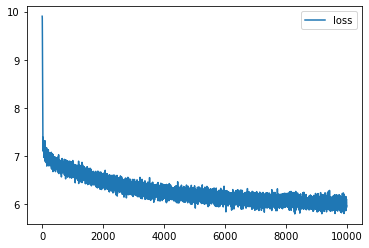

In [36]:
# Plot loss per iteration
plt.plot(r.history['loss'], label='loss')
plt.legend();

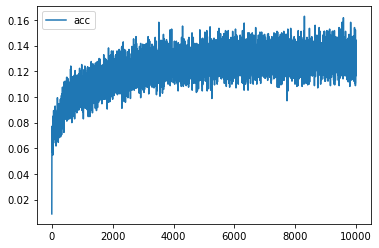

In [37]:
# Plot accuracy per iteration
plt.plot(r.history['accuracy'], label='acc')
plt.legend();

In [38]:
# Get embedding matrix
embeddings = model.layers[1].get_weights()[0]
embeddings

array([[-0.03348692,  0.04014813,  0.01309742, ...,  0.0021897 ,
         0.01371355,  0.00642073],
       [-0.46942744, -1.4237839 , -0.18173096, ..., -0.04038358,
        -0.3720096 ,  0.1867653 ],
       [ 0.51542944, -0.09506573,  0.12127436, ...,  0.73013645,
         0.87664074, -0.20924287],
       ...,
       [-0.10729561, -0.03910025, -0.14545283, ...,  0.11107653,
        -0.03492973,  0.1344595 ],
       [ 0.1170686 , -0.24508186, -0.09178864, ..., -0.15861666,
        -0.7917423 , -0.00276595],
       [ 0.16298017,  0.01178331,  0.35235983, ...,  0.42954397,
        -0.11546321, -0.2521337 ]], dtype=float32)

In [39]:
from sklearn.neighbors import NearestNeighbors
neighbors = NearestNeighbors(n_neighbors=5, algorithm='ball_tree')
neighbors.fit(embeddings)

NearestNeighbors(algorithm='ball_tree')

In [40]:
queen_idx = tokenizer.word_index['queen']
queen = embeddings[queen_idx:queen_idx + 1]
distances, indices = neighbors.kneighbors(queen)
indices

array([[ 903, 2032,  187,  879, 3421]])

In [41]:
for idx in indices[0]:
  word = tokenizer.index_word[idx]
  print(word)

queen
elizabeth
king
mary
princess


In [42]:
def print_neighbors(query):
  query_idx = tokenizer.word_index[query]
  query = embeddings[query_idx:query_idx + 1]
  distances, indices = neighbors.kneighbors(query)
  for idx in indices[0]:
    word = tokenizer.index_word[idx]
    print(word)

In [43]:
print_neighbors('uncle')

uncle
cousin
grandfather
mentor
father


In [44]:
print_neighbors('paris')

paris
venice
vienna
florence
milan


In [45]:
print_neighbors('japan')

japan
taiwan
turkey
singapore
pakistan


In [46]:
print_neighbors('election')

election
presidential
elections
vote
candidate


In [47]:
print_neighbors('california')

california
texas
florida
illinois
michigan


In [48]:
# king - man = queen - woman

def get_embedding(word):
  idx = tokenizer.word_index[word]
  return embeddings[idx:idx + 1]

king = get_embedding('king')
man = get_embedding('man')
woman = get_embedding('woman')
query = king - man + woman

distances, indices = neighbors.kneighbors(query)
for idx in indices[0]:
  word = tokenizer.index_word[idx]
  print(word)

king
queen
henry
elizabeth
daughter


In [49]:
# england - english = australia - australian

king = get_embedding('england')
man = get_embedding('english')
woman = get_embedding('australian')
query = king - man + woman

distances, indices = neighbors.kneighbors(query)
for idx in indices[0]:
  word = tokenizer.index_word[idx]
  print(word)

australia
maryland
virginia
louisiana
victoria
